<a href="https://colab.research.google.com/github/waynemaranga/phoenixke-masterclass/blob/main/Capstone_Project_Group_7_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Capstone Project Group 7`

Dennis, Joan, Lisa and Wayne.

`The Best`

## Imports

imports the necessary Python libraries for the project:
`requests`: To send HTTP requests and get the HTML content of web pages.`BeautifulSoup` (from `bs4`): To parse the HTML content and make it easy to navigate and extract data. `time`: To add delays between requests to avoid overloading the server. `csv`: To handle writing the scraped data into CSV files. `os`: To interact with the operating system, specifically for creating directories.

In [20]:
import requests
from bs4 import BeautifulSoup
import time
import csv # for csv file operations
import os # to access operating system

## Request Parameters

This section defines the global constants that will be used throughout the scraping process. `BASE_URL`: Sets the target website to http://books.toscrape.com/. `HEADERS`: Defines a user-agent to make the script's requests look like they're coming from a browser. `SLEEP_TIME`: Sets a 1-second delay between requests to be respectful to the website's server.

In [21]:
BASE_URL = "http://books.toscrape.com/" # one base to request multiple URLs/pages without repeating too many times
HEADERS = {"User-Agent": "ScraperBotbyLisaDennisandWayne"} # a request header; carries info about the request; for scraping rules
SLEEP_TIME = 1  # seconds between requests; some delays for respecting sites

## Core Scraping Functions

This part contains the main functions responsible for fetching and parsing the data. `get_soup(url)`: This function takes a URL, fetches the page content, and returns it as a `BeautifulSoup` object. It includes error handling to catch and report issues if a URL is invalid or fails to load. `convert_star_rating(star_str)`: A helper function that converts the book's star rating from text (e.g., "Three") to a numerical value (e.g., 3). `extract_product_info(product)`: This function is designed to parse the HTML of a single book listing. It extracts the Title, Price, Availability, Star Rating, and URL for one book. It also includes basic error handling.

### `get_soup(url)`

In [22]:
# -- A soup is a site's html as a string
def get_soup(url):
    try:
        response = requests.get(url, headers=HEADERS) # gets the HTML as raw html using the headers
        response.raise_for_status() # raises error if any with http error code
        return BeautifulSoup(response.text, "html.parser") # returns the soup and the parser to use

        # This except block handles any error with the requests function for example invalid urls
    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Failed to fetch {url} - {e}")
        return None
    except Exception as ex:
      print(f"[ERROR] Encountered ambiguous error: - {ex}")
      return None

### Demonstrating error handling

In [23]:
print(str(get_soup("https://www.facebook.com"))[:99])

<!DOCTYPE html>

<html class="no_js" id="facebook" lang="sw">
<head><meta charset="utf-8"/><meta co


In [24]:
print(get_soup("www.facebook.com"))

[ERROR] Failed to fetch www.facebook.com - Invalid URL 'www.facebook.com': No scheme supplied. Perhaps you meant https://www.facebook.com?
None


In [25]:
print(get_soup("https://www.facebooksz.com"))

[ERROR] Failed to fetch https://www.facebooksz.com - HTTPSConnectionPool(host='www.facebooksz.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.facebooksz.com'. (_ssl.c:1010)")))
None


### `extract_product_info(product)`

In [26]:
# -- This function is tailored the books to scrape site
def extract_product_info(product):
    try:
      # This information is got from inspecting the page using developer tools
      # Each item (likely) belongs in a tag, a nested tag or something close to it
      # 1. Inspect page 2. Inspect page using
        title = product.h3.a['title'].strip()
        relative_url = product.h3.a['href']
        product_url = BASE_URL + 'catalogue/' + relative_url.replace('../../../', '')
        price = product.select_one('.price_color').text.strip().replace('£', '') # .select_one(identifier) finds any html element using this identifier/class/attribute and returns a list or one item
        availability = product.select_one('.availability').text.strip()
        star_class = product.select_one('.star-rating')['class']
        star_rating = convert_star_rating(star_class[1]) # converts html star elements into a rating

        # Go to individual product page for verification or more details
        return {
            "Title": title,
            "Price": price,
            "Availability": availability,
            "Star Rating": star_rating,
            "URL": product_url
        }
        # handles any error
    except Exception as e: # uses Python's base Exception which handles all exceptions
        print(f"[ERROR] Failed to parse product info - {e}")
        return None

    except KeyboardInterrupt as k:
      return None

### `convert_star_rating(star_str)`

In [27]:
# Not essential
def convert_star_rating(star_str):
    stars = {
        "One": 1, "Two": 2, "Three": 3,
        "Four": 4, "Five": 5
    }
    return stars.get(star_str, 0)

## Category and Pagination Handling

These functions manage the multi-level scraping required for the site structure. `get_categories()`: This function scrapes the website's homepage to get a list of all available book categories and their unique URLs. `get_category_pages(category_url)`: This function handles pagination. For any given category page, it checks how many pages of books exist and returns a complete list of URLs for all pages in that category.

### `get_categories()`

In [28]:
# Getting categories in the first place from homepage
def get_categories():
    soup = get_soup(BASE_URL) # get the soup of the homepage
    if not soup:
        return {}

    category_links = soup.select('.side_categories ul li ul li a') # from the soup get the list and urls of categories
    categories = {} # dictionary for category name and url
    for a in category_links:
        name = a.text.strip()
        rel_url = a['href'] # e.g '/catalogue/category/books_1/index.html'
        full_url = BASE_URL + rel_url # add base url to relative url : https://books.toscrape.com/catalogue/category/books_1/index.html
        categories[name] = full_url
    return categories

In [29]:
print(get_categories())
print(list(get_categories().keys()))

{'Travel': 'http://books.toscrape.com/catalogue/category/books/travel_2/index.html', 'Mystery': 'http://books.toscrape.com/catalogue/category/books/mystery_3/index.html', 'Historical Fiction': 'http://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html', 'Sequential Art': 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html', 'Classics': 'http://books.toscrape.com/catalogue/category/books/classics_6/index.html', 'Philosophy': 'http://books.toscrape.com/catalogue/category/books/philosophy_7/index.html', 'Romance': 'http://books.toscrape.com/catalogue/category/books/romance_8/index.html', 'Womens Fiction': 'http://books.toscrape.com/catalogue/category/books/womens-fiction_9/index.html', 'Fiction': 'http://books.toscrape.com/catalogue/category/books/fiction_10/index.html', 'Childrens': 'http://books.toscrape.com/catalogue/category/books/childrens_11/index.html', 'Religion': 'http://books.toscrape.com/catalogue/category/books/religion_12/i

### `get_category_pages(category_url)`

In [30]:
# Since the page has many categories; for each category get it's soup
# Pagination function; made possible by inspection
def get_category_pages(category_url):
    pages = [category_url]
    soup = get_soup(category_url)
    if not soup:
        return []

    pager = soup.select_one('.current') # select current page
    if pager:
        total_pages = int(pager.text.strip().split()[-1]) # get no. of pages
        for page_num in range(2, total_pages + 1):
            paginated_url = category_url.replace('index.html', f'page-{page_num}.html') # replace current page with page no.s
            pages.append(paginated_url)
    return pages

In [31]:
print(get_category_pages("http://books.toscrape.com/catalogue/category/books/default_15/index.html"))

['http://books.toscrape.com/catalogue/category/books/default_15/index.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-2.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-3.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-4.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-5.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-6.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-7.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-8.html']


In [32]:
print(get_category_pages("http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html"))

['http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html', 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/page-2.html', 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/page-3.html', 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/page-4.html']


## Execution

This section brings all the functions together to run the scraper and save the results. `scrape_category(...)`: An orchestrator function that takes a category name and URL, gets all of its pages, scrapes the product info from each page, and then calls the save_to_csv function. `save_to_csv(...)`: This function takes the scraped data for a category and writes it to a uniquely named CSV file (e.g., mystery.csv) inside an output directory. `main()`: The main function that starts the process. In this notebook, it's configured to scrape the first three categories as a sample run. The final cells in this section execute the scraper by calling `main()` and then list the files in the output directory to confirm that the CSV files were created successfully.

### Output `folder`

In [33]:
import pathlib
folder = pathlib.Path.cwd() / "output"  # create a path to the output folder
if not folder.exists():
    folder.mkdir(parents=False)  # create the directory if it doesn't exist
print(folder)


/home/neo/Projects/phoenixke-masterclass/assignment-3/output


### `save_to_csv(category, data)`

In [34]:
def save_to_csv(category, data):
    filename = f"{folder}/{category.replace(' ', '_').lower()}.csv"
    with open(filename, "w", newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=["Title", "Price", "Availability", "Star Rating", "URL"])
        writer.writeheader()
        for row in data:
            writer.writerow(row)
    print(f"[SUCCESS] Saved {len(data)} items to {filename}")


### `scrape_category(category_name, category_url)`

In [35]:
# Scrape category...
def scrape_category(category_name, category_url):
    print(f"\n[INFO] Scraping category: {category_name}")
    all_data = []
    pages = get_category_pages(category_url) # all pages in category to be scraped

    for page_url in pages:
        print(f"[INFO] Scraping page: {page_url}")
        soup = get_soup(page_url) # get the soup
        if not soup:
            continue

        products = soup.select('article.product_pod') # find a product card
        for product in products:
            info = extract_product_info(product) # from product extract info e.g title and price
            if info:
                all_data.append(info)
        time.sleep(SLEEP_TIME)

    save_to_csv(category_name, all_data)

In [36]:
categories_list = list(get_categories().keys())
try:
    categories_list.remove('Default')
except ValueError:
    print("'Default' not found in categories_list. Skipping removal.")

try:
    categories_list.remove('Add a Comment')
except ValueError:
    print("'Add a Comment' not found in categories_list. Skipping removal.")


print(categories_list)
# categories_list


'Add a Comment' not found in categories_list. Skipping removal.
['Travel', 'Mystery', 'Historical Fiction', 'Sequential Art', 'Classics', 'Philosophy', 'Romance', 'Womens Fiction', 'Fiction', 'Childrens', 'Religion', 'Nonfiction', 'Music', 'Science Fiction', 'Sports and Games', 'Add a comment', 'Fantasy', 'New Adult', 'Young Adult', 'Science', 'Poetry', 'Paranormal', 'Art', 'Psychology', 'Autobiography', 'Parenting', 'Adult Fiction', 'Humor', 'Horror', 'History', 'Food and Drink', 'Christian Fiction', 'Business', 'Biography', 'Thriller', 'Contemporary', 'Spirituality', 'Academic', 'Self Help', 'Historical', 'Christian', 'Suspense', 'Short Stories', 'Novels', 'Health', 'Politics', 'Cultural', 'Erotica', 'Crime']


### `main()`

In [37]:
def main():
    categories = get_categories() # get all categories
    if not categories:
        print("[ERROR] No categories found.")
        return

    selected_categories = list(categories.items())[:10]  #
    # selected_categories = list(categories.items())  # Take any 5 categories; these are dictionaries
    for category_name, category_url in selected_categories: # name is key, url is value
        scrape_category(category_name, category_url) # scrape and write to csv


In [38]:
main()


[INFO] Scraping category: Travel
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/travel_2/index.html
[SUCCESS] Saved 11 items to /home/neo/Projects/phoenixke-masterclass/assignment-3/output/travel.csv

[INFO] Scraping category: Mystery
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/mystery_3/index.html
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/mystery_3/page-2.html
[SUCCESS] Saved 32 items to /home/neo/Projects/phoenixke-masterclass/assignment-3/output/mystery.csv

[INFO] Scraping category: Historical Fiction
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/historical-fiction_4/page-2.html
[SUCCESS] Saved 26 items to /home/neo/Projects/phoenixke-masterclass/assignment-3/output/historical_fiction.csv

[INFO] Scraping category: Sequential Art
[INFO] Scraping page: http://books.to

## Setup analysis and visualisation

This is where the notebook transitions from scraping to analysis. The script reads all the newly created CSV files from the output directory and loads them into `pandas` `DataFrame` objects. It imports the visualization libraries `matplotlib` and `seaborn`. The DataFrames are then cleaned and prepared for analysis by dropping unnecessary columns and fixing data types. Finally, all the individual DataFrames are combined into a single combined_df to make plotting easier.

### Output `files`

In [39]:
files = os.listdir(folder)
print("Files found:", files)

if 'default.csv' in files:
    os.remove(os.path.join(folder, 'default.csv'))
    print("Removed default.csv")
if 'add_a_comment.csv' in files:
    os.remove(os.path.join(folder, 'add_a_comment.csv'))
    print("Removed add_a_comment.csv")

Files found: ['.gitignore', 'mystery.csv', 'historical_fiction.csv', 'sample.csv', 'travel.csv', 'sequential_art.csv', 'classics.csv', 'philosophy.csv', 'romance.csv', 'womens_fiction.csv', 'fiction.csv', 'childrens.csv']


In [40]:
import pandas as pd

dfs = {} # all the dataframes
for file_name in files:
  if file_name.endswith('.csv'):
    df_name = file_name.replace('.csv', '')
    try:
      dfs[df_name] = pd.read_csv(os.path.join(folder, file_name))
      # print(f"Successfully created DataFrame for {file_name}")
    except Exception as e:
      print(f"[ERROR] Failed to create DataFrame for {file_name} - {e}")

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [42]:
dfs = {} # all the dataframes
for file_name in files:
  if file_name.endswith('.csv'):
    df_name = file_name.replace('.csv', '')
    try:
      dfs[df_name] = pd.read_csv(os.path.join(folder, file_name))
      # print(f"Successfully created DataFrame for {file_name}")
    except Exception as e:
      print(f"[ERROR] Failed to create DataFrame for {file_name} - {e}")

In [43]:
dataframes = dfs.values()

for df in dataframes:
    if 'Title' in df.columns:
        df.drop('Title', axis=1, inplace=True)
    if 'URL' in df.columns:
        df.drop('URL', axis=1, inplace=True)
    if 'Availability' in df.columns:
        df.drop('Availability', axis=1, inplace=True)
    if 'Price' in df.columns:
        df['Price'] = df['Price'].astype(str).str.replace('Â', '', regex=False)


In [44]:
# print(list(dfs.values())[5])

In [45]:
category_names = [name.replace('_', ' ').title() for name in dfs.keys()]
# category_names.remove('Default')
print(category_names)

['Mystery', 'Historical Fiction', 'Sample', 'Travel', 'Sequential Art', 'Classics', 'Philosophy', 'Romance', 'Womens Fiction', 'Fiction', 'Childrens']


## Statistical Analysis

Before plotting, this section computes and displays key statistics from the scraped data. It calculates the total number of books, average price, and average rating for each category as well as the overall totals. The results are printed in a formatted summary.

In [46]:
total_books_overall = 0
total_price_overall = 0.0
total_rating_overall = 0.0
total_books_count = 0

print("--- Basic Statistics per Dataframe ---")
for i, df in enumerate(dataframes):
    category_name = category_names[i]
    total_books_df = len(df)
    avg_price_df = df['Price'].astype(float).mean() if total_books_df > 0 else 0
    avg_rating_df = df['Star Rating'].mean() if total_books_df > 0 else 0

    print(f"\nCategory: {category_name}")
    print(f"Total books: {total_books_df}")
    print(f"Average book price: £{avg_price_df:.2f}")
    print(f"Average rating: {avg_rating_df:.2f}")

    total_books_overall += total_books_df
    total_price_overall += df['Price'].astype(float).sum()
    total_rating_overall += df['Star Rating'].sum()
    total_books_count += total_books_df

print("\n--- Overall Basic Statistics ---")
avg_price_overall = total_price_overall / total_books_count if total_books_count > 0 else 0
avg_rating_overall = total_rating_overall / total_books_count if total_books_count > 0 else 0

print(f"Total books overall: {total_books_overall}")
print(f"Average price overall: £{avg_price_overall:.2f}")
print(f"Average rating overall: {avg_rating_overall:.2f}")

print("\n--- Average Rating per Category ---")
for i, df in enumerate(dataframes):
    category_name = category_names[i]
    avg_rating_df = df['Star Rating'].mean() if len(df) > 0 else 0
    print(f"{category_name}: {avg_rating_df:.2f}")


--- Basic Statistics per Dataframe ---

Category: Mystery
Total books: 32
Average book price: £31.72
Average rating: 2.94

Category: Historical Fiction
Total books: 26
Average book price: £33.64
Average rating: 3.23

Category: Sample
Total books: 0
Average book price: £0.00
Average rating: 0.00

Category: Travel
Total books: 11
Average book price: £39.79
Average rating: 2.73

Category: Sequential Art
Total books: 75
Average book price: £34.57
Average rating: 2.97

Category: Classics
Total books: 19
Average book price: £36.55
Average rating: 2.47

Category: Philosophy
Total books: 11
Average book price: £33.56
Average rating: 2.36

Category: Romance
Total books: 35
Average book price: £33.93
Average rating: 2.63

Category: Womens Fiction
Total books: 17
Average book price: £36.79
Average rating: 3.12

Category: Fiction
Total books: 65
Average book price: £36.07
Average rating: 3.18

Category: Childrens
Total books: 29
Average book price: £32.64
Average rating: 2.62

--- Overall Basic St

In [47]:
# Compute statistics
category_book_counts = {name: len(df) for name, df in zip(category_names, dataframes)}
category_avg_prices = {name: df['Price'].astype(float).mean() if len(df) > 0 else 0 for name, df in zip(category_names, dataframes)}
category_ratings = {name: df['Star Rating'].mean() if len(df) > 0 else 0 for name, df in zip(category_names, dataframes)}


## Data Visualisations

The final section is dedicated to creating a variety of plots to visualize the data insights.

**Bar Graphs**: Three separate bar charts are created to show: Total books per category, Average price per category, Average star rating per category.

**Box Plots**: Two box plots are generated to show the distribution of: Prices within each category, Star ratings within each category,

**Heatmap**: A heatmap is created to visualize the distribution of star ratings (1 through 5) across all scraped categories.

**Histograms**: Two histograms are generated to show the overall distribution of prices and star ratings across all books

In [48]:
# Combine for distribution plots
combined_df = pd.concat([df.assign(Category=cat) for df, cat in zip(dataframes, category_names)], ignore_index=True)
combined_df['Price'] = combined_df['Price'].astype(float)

### Bar Graphs

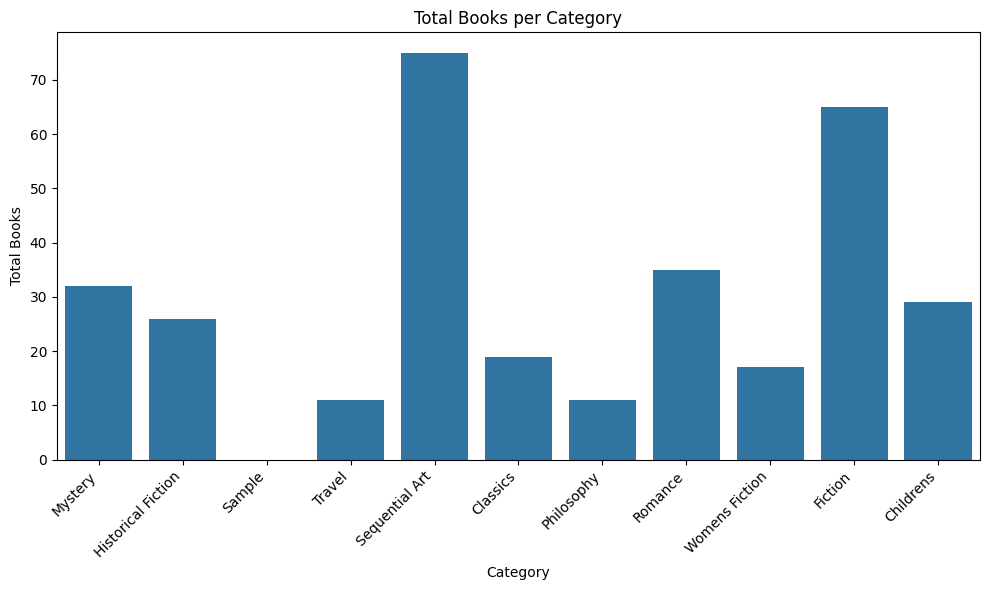

In [49]:
# Bar Graph - Total Books per Category
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_book_counts.keys()), y=list(category_book_counts.values()))
plt.title('Total Books per Category')
plt.xlabel('Category')
plt.ylabel('Total Books')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

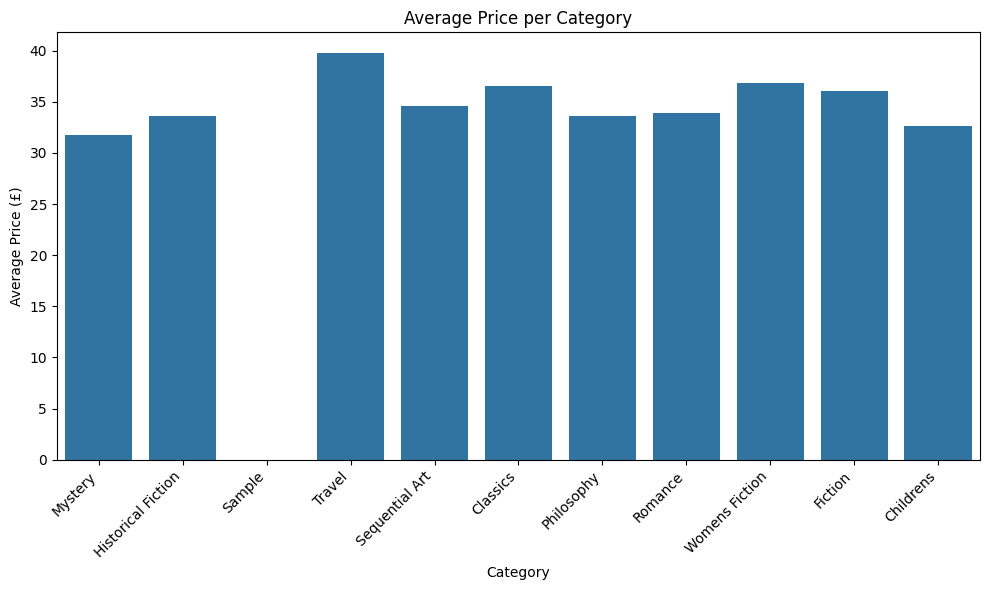

In [50]:
# Bar Graph - Average Price per Category
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_avg_prices.keys()), y=list(category_avg_prices.values()))
plt.title('Average Price per Category')
plt.xlabel('Category')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

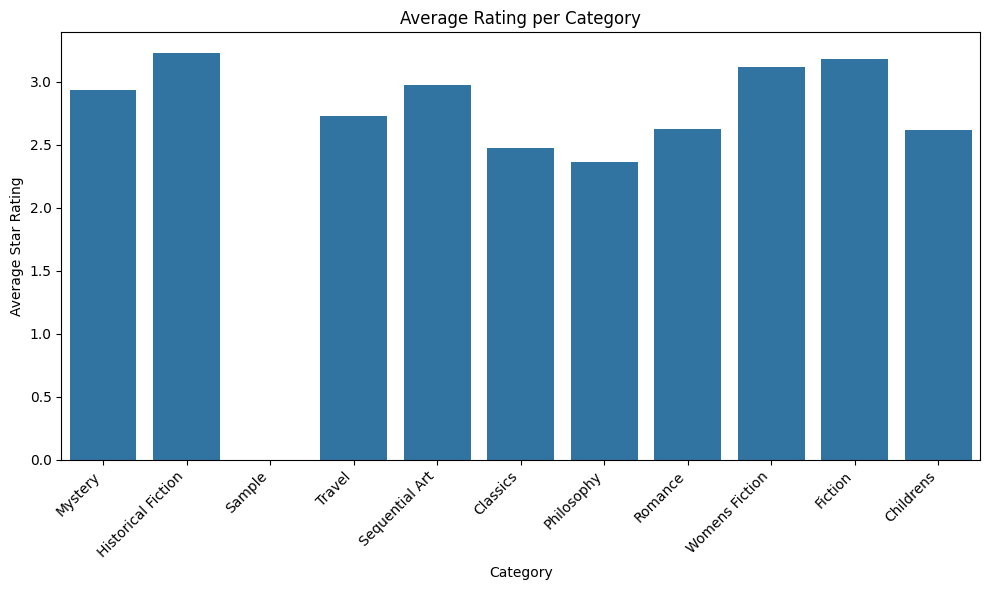

In [51]:
# Bar Graph - Average Rating per Category
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_ratings.keys()), y=list(category_ratings.values()))
plt.title('Average Rating per Category')
plt.xlabel('Category')
plt.ylabel('Average Star Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Box plots

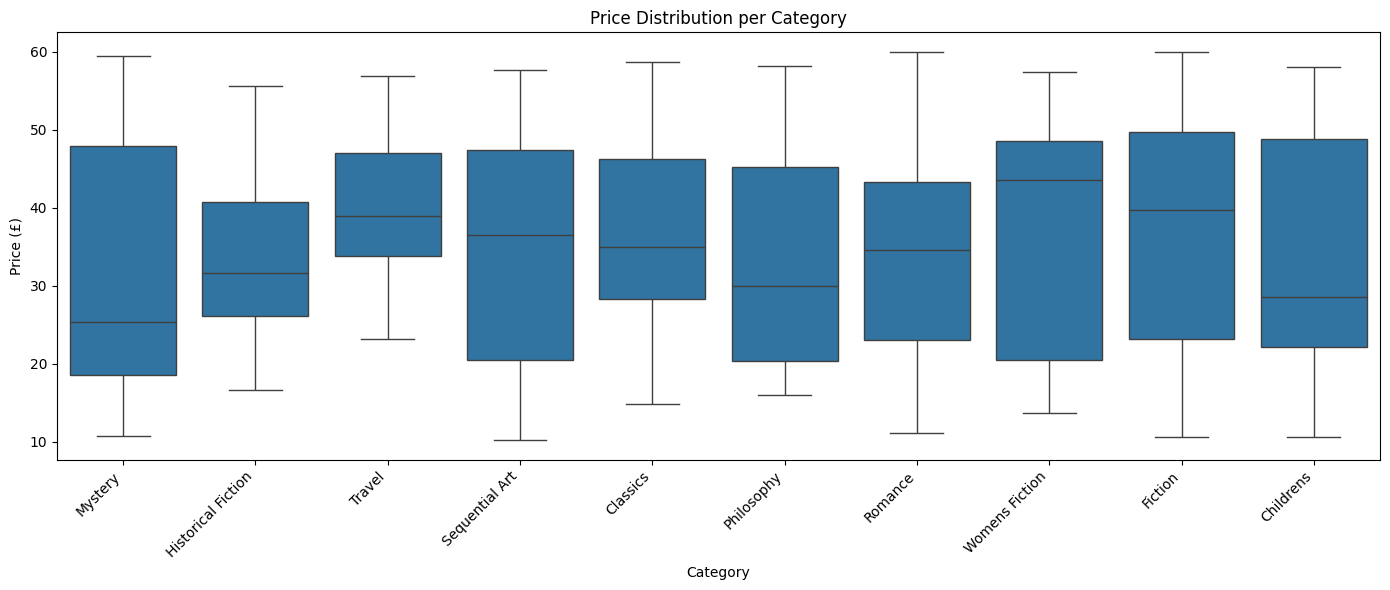

In [52]:
# Box Plots for Price Distributions
plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
sns.boxplot(x='Category', y='Price', data=combined_df)
plt.title('Price Distribution per Category')
plt.xlabel('Category')
plt.ylabel('Price (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

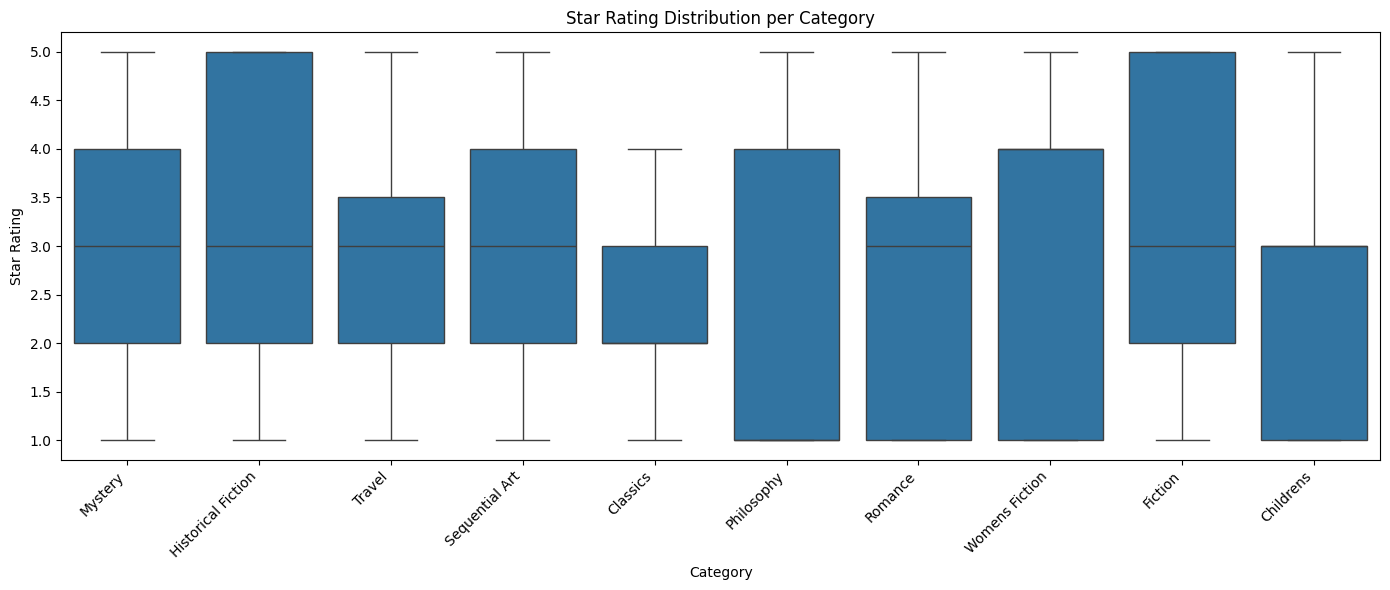

In [53]:
# Box Plots for Rating Distributions
plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 2)
sns.boxplot(x='Category', y='Star Rating', data=combined_df)
plt.title('Star Rating Distribution per Category')
plt.xlabel('Category')
plt.ylabel('Star Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Histogram

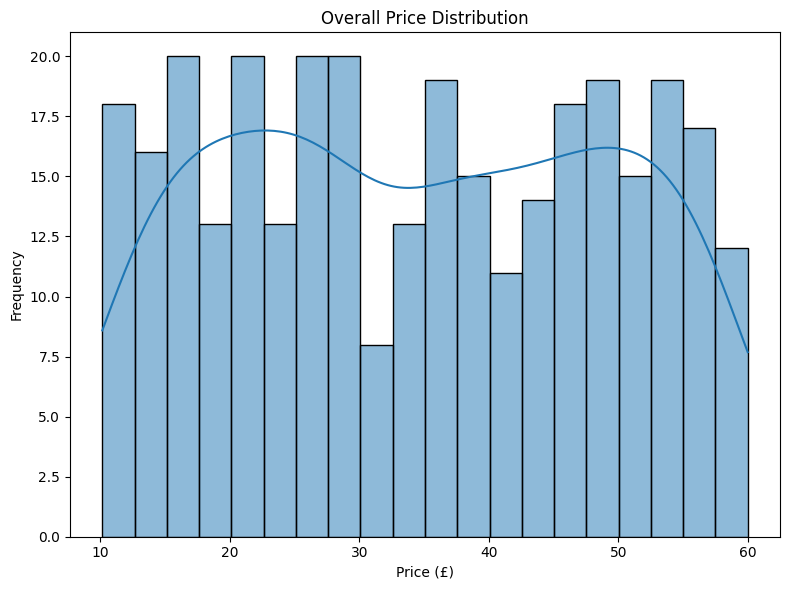

In [54]:
# Histogram - Overall Price Distribution
plt.figure(figsize=(8, 6))
sns.histplot(combined_df['Price'], bins=20, kde=True)
plt.title('Overall Price Distribution')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

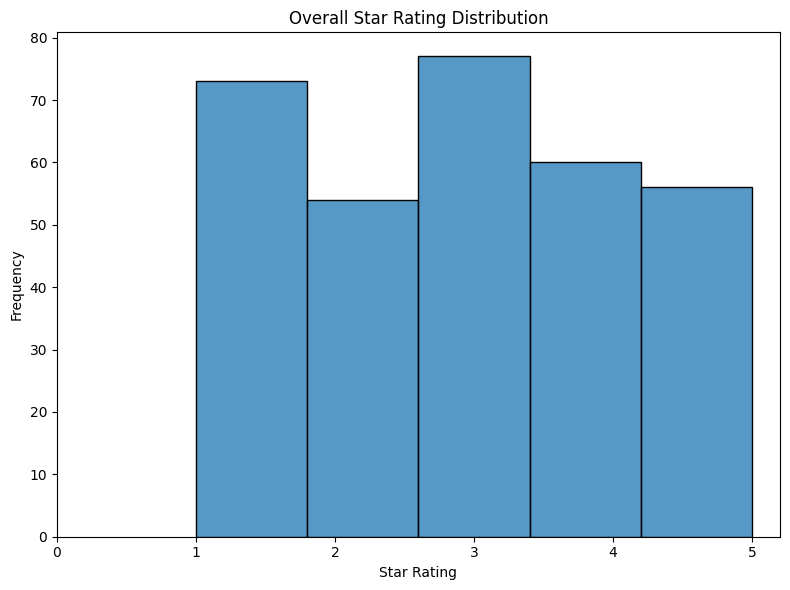

In [55]:
# Histogram - Overall Star Rating Distribution
plt.figure(figsize=(8, 6))
sns.histplot(combined_df['Star Rating'], bins=5, kde=False)
plt.title('Overall Star Rating Distribution')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.xticks(range(6))
plt.tight_layout()
plt.show()

## Heatmap

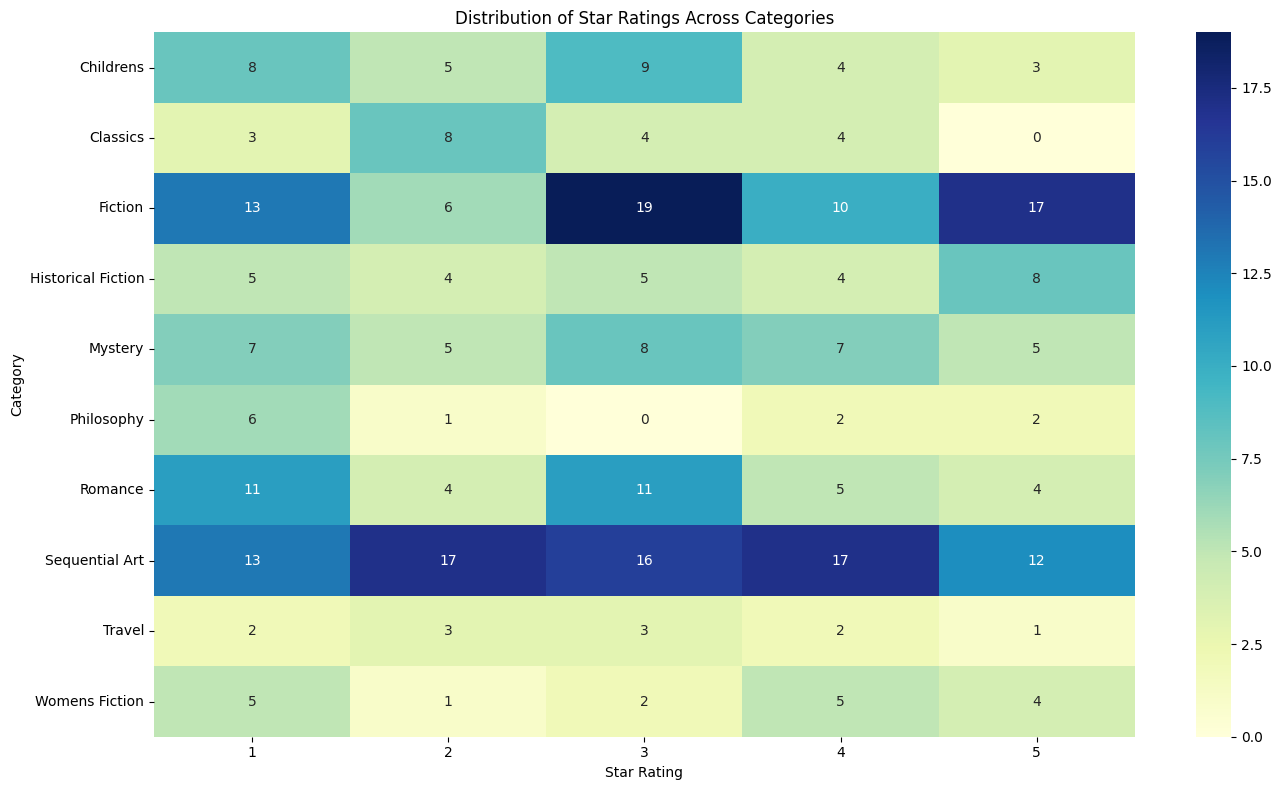

In [56]:
# Heatmap - Distribution of Star Ratings Across Categories
rating_category_counts = combined_df.groupby(['Category', 'Star Rating']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(rating_category_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribution of Star Ratings Across Categories')
plt.xlabel('Star Rating')
plt.ylabel('Category')
plt.tight_layout()
plt.show()
